#  DENOISING AUTOENCODER

AUTHOR: [ARIHARASUDHAN](http://arihara-sudhan.github.io)      
DATE: 16/10/2024




> Guys, I am using a video as data! I add noise following Gaussian Distribution to each frames and create a noisy dataset... Later, I train a Denoising Auto-Encoder Network with these data!

**EXTRACT FRAMES OF A VIDEO**

In [1]:
import cv2
import os

def extract_frames(video_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_path = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_path, frame)
        frame_count += 1

    cap.release()
    print(f"Extracted {frame_count} frames.")
    
video_path = '/kaggle/input/video-here/VID.mov'
output_folder = '/kaggle/working/Frames'
extract_frames(video_path, output_folder)

Extracted 216 frames.


**MAKING A DATASET**

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class FrameDataset(Dataset):
    def __init__(self, frames_folder, transform=None):
        self.frames_folder = frames_folder
        self.transform = transform
        self.frames = sorted(os.listdir(frames_folder))
        
    def __len__(self):
        return len(self.frames)
    
    def __getitem__(self, idx):
        frame_path = os.path.join(self.frames_folder, self.frames[idx])
        image = Image.open(frame_path)
        
        if self.transform:
            image = self.transform(image)
        
        return image

transform = transforms.ToTensor()
frames_folder = '/kaggle/working/Frames'
frame_dataset = FrameDataset(frames_folder, transform=transform)

In [3]:
from torch.utils.data import DataLoader
batch_size = 4
data_loader = DataLoader(frame_dataset, batch_size=batch_size, shuffle=True)

**MODEL ARCHITECTURE**

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        
        # First block: input --> 64 filters
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Second block: 64 filters --> 128 filters
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Third block: 128 filters --> 256 filters
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        # Pooling and dropout layer for regularization
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        
        # Deconv block: 256 --> 128 filters
        self.t_conv1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.t_bn1 = nn.BatchNorm2d(128)
        self.t_conv2 = nn.ConvTranspose2d(128, 128, 3, padding=1)
        self.t_bn2 = nn.BatchNorm2d(128)

        # Deconv block: 128 --> 64 filters
        self.t_conv3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.t_bn3 = nn.BatchNorm2d(64)
        self.t_conv4 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.t_bn4 = nn.BatchNorm2d(64)
        
        # Deconv block: 64 --> 32 filters
        self.t_conv5 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.t_bn5 = nn.BatchNorm2d(32)
        
        # Final conv layer: 32 --> 1 (output depth)
        self.conv_out = nn.Conv2d(32, 3, 3, padding=1)

    def forward(self, x):
        # First block
        x1 = F.relu(self.bn1(self.conv1(x)))
        x1 = F.relu(self.bn2(self.conv2(x1)))
        x1 = self.pool(x1)
        x1 = self.dropout(x1)
        
        # Second block
        x2 = F.relu(self.bn3(self.conv3(x1)))
        x2 = F.relu(self.bn4(self.conv4(x2)))
        x2 = self.pool(x2)
        x2 = self.dropout(x2)
        
        # Third block
        x3 = F.relu(self.bn5(self.conv5(x2)))
        x3 = F.relu(self.bn6(self.conv6(x3)))
        x3 = self.pool(x3)
        x3 = self.dropout(x3)
        
        # First deconv block
        x = F.relu(self.t_bn1(self.t_conv1(x3)))
        x = F.relu(self.t_bn2(self.t_conv2(x)))
        
        # Second deconv block
        x = F.relu(self.t_bn3(self.t_conv3(x)))
        x = F.relu(self.t_bn4(self.t_conv4(x)))
        
        # Third deconv block
        x = F.relu(self.t_bn5(self.t_conv5(x)))
        
        # Final output layer (with sigmoid for denoising)
        x = torch.sigmoid(self.conv_out(x))
        
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EncoderDecoder().to(device)

In [5]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 50

**HOW IS MY NOISE ADDED?**

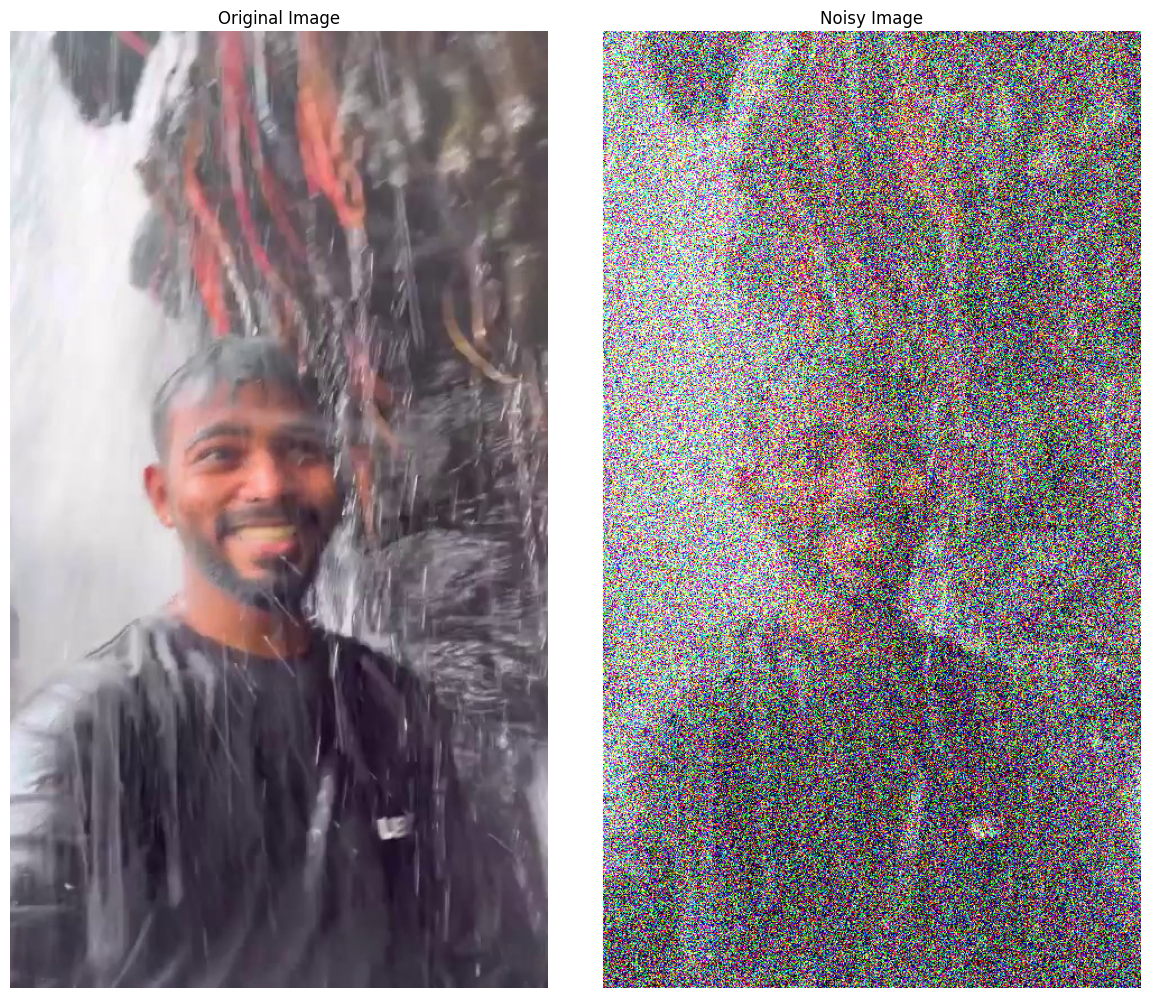

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch

model_image = None
for images in data_loader:
    model_image = images
    break

original_image = model_image[0].unsqueeze(0)
original_image = original_image.to(device)
noise_factor = 0.75
noisy_image = original_image + noise_factor * torch.randn(*original_image.shape).to(device)
noisy_image = torch.clamp(noisy_image, 0., 1.)
original_image = original_image.cpu().numpy().squeeze().transpose(1, 2, 0)
noisy_image = noisy_image.cpu().numpy().squeeze().transpose(1, 2, 0)
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Noisy Image')
plt.imshow(noisy_image)
plt.axis('off')
plt.tight_layout()
plt.show()


**TRAINING**

In [ ]:
for epoch in range(1, n_epochs + 1):
    train_loss = 0.0
    for data in data_loader:
        images = data.to(device)
        noisy_imgs = images + noise_factor * torch.randn(*images.shape).to(device)
        noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)
        
        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        outputs = F.interpolate(outputs, size=images.shape[2:], mode='bilinear', align_corners=False)  # Ensure size match
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    train_loss /= len(data_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

    with torch.no_grad():
        fixed_image = images[0].unsqueeze(0)
        fixed_noisy_image = noisy_imgs[0].unsqueeze(0)

        fixed_denoised_image = model(fixed_noisy_image.to(device))
        fixed_image_np = fixed_image.cpu().numpy().squeeze().transpose(1, 2, 0)
        fixed_noisy_image_np = fixed_noisy_image.cpu().numpy().squeeze().transpose(1, 2, 0)
        fixed_denoised_image_np = fixed_denoised_image.cpu().numpy().squeeze().transpose(1, 2, 0)
        fixed_denoised_image_np = np.clip(fixed_denoised_image_np, 0, 1)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(fixed_image_np)
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.title('Noisy Image')
        plt.imshow(fixed_noisy_image_np)
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.title('Denoised Image')
        plt.imshow(fixed_denoised_image_np)
        plt.axis('off')
        plt.show()

**A DENOISED VIDEO**

In [ ]:
import os

frames_path = '/kaggle/working/Frames/'
noisy_video_output = '/kaggle/working/noisy_video.mp4'
denoised_video_output = '/kaggle/working/denoised_video.mp4'
fps = 24
frame_size = None
image_files = sorted([os.path.join(frames_path, f) for f in os.listdir(frames_path) if f.endswith('.jpg')])
print(image_files)
noisy_out = None
denoised_out = None

for i, img_file in enumerate(image_files):
    img = Image.open(img_file)
    img = np.array(img) / 255.0
    noise_factor = 0.75
    noisy_img = img + noise_factor * np.random.randn(*img.shape)
    noisy_img = np.clip(noisy_img, 0., 1.)
    img_tensor = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float().to(device)
    noisy_img_tensor = torch.tensor(noisy_img).permute(2, 0, 1).unsqueeze(0).float().to(device)
    
    with torch.no_grad():
        denoised_img_tensor = model(noisy_img_tensor)
        denoised_img_tensor = F.interpolate(denoised_img_tensor, size=img_tensor.shape[2:], mode='bilinear', align_corners=False)
    
    noisy_img_np = noisy_img_tensor.cpu().numpy().squeeze().transpose(1, 2, 0)
    denoised_img_np = denoised_img_tensor.cpu().numpy().squeeze().transpose(1, 2, 0)
    denoised_img_np = np.clip(denoised_img_np, 0, 1)

    noisy_frame = (noisy_img_np * 255).astype(np.uint8)
    denoised_frame = (denoised_img_np * 255).astype(np.uint8)

    if frame_size is None:
        frame_size = (noisy_frame.shape[1], noisy_frame.shape[0])
        noisy_out = cv2.VideoWriter(noisy_video_output, cv2.VideoWriter_fourcc(*'mp4v'), fps, frame_size)
        denoised_out = cv2.VideoWriter(denoised_video_output, cv2.VideoWriter_fourcc(*'mp4v'), fps, frame_size)

    if noisy_out is not None and denoised_out is not None:
        noisy_out.write(cv2.cvtColor(noisy_frame, cv2.COLOR_RGB2BGR))
        denoised_out.write(cv2.cvtColor(denoised_frame, cv2.COLOR_RGB2BGR))

noisy_out.release()
denoised_out.release()